# COVID-19 Analysis

## L'Autore

#### Guido Bei

* *Bachelor degree*: Economia e Commercio, UniPi
* *Master degree*: Statistica e Data Science, UniFi
* *GitHub profile*: https://github.com/guidobei
* *Computer*: HP Notebook
* *Operating system*: Windows 10 Home
* *Processor*: Intel Core i5-6200U CPU @ 2.30GHz 2.40GHz
* *Installed RAM*: 4,00 GB
* *System type*: 64-bit operating system, x64-based processor
* *IDE*: IDLE
* *Environment*: Python Virtual Environment
    * *Libraries installed*:
        * `jupyter`
        * `numpy`
        * `pandas`
        * `matplotlib`
        * `networkx`

In [1]:
import sys
print("Python version: {}".format(sys.version))

Python version: 3.8.1 (v3.8.1:1b293b6006, Dec 18 2019, 14:08:53) 
[Clang 6.0 (clang-600.0.57)]


## Introduzione

Cominciamo importando tutti i moduli che serviranno nel corso del progetto.

In [2]:
import numpy as np
import pandas as pd
import json
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx
import requests

In [3]:
# modules version

version = lambda x: print("{}=={}".format(x.__name__, x.__version__))

version(np)
version(pd)
version(mpl)
version(networkx)
version(requests)

numpy==1.18.5
pandas==1.0.1
matplotlib==3.3.2
networkx==2.5
requests==2.25.0


### Il Dataset

Il [dataset](https://github.com/pcm-dpc/COVID-19) proposto è quello reso disponibile dal *Dipartimento della Protezione Civile* sulla piattaforma *GitHub*. 

Il dataset contiene una moltitudine di file, a partire da un livello di aggregazione nazionale fino a quello provinciale, in vari formati: noi utilizzeremo i file `JSON` sulle [province](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json) e sulle [regioni](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json).

Il dataset è aggiornato quotidianamente alle ore 17:00(UTC+2) ed il principale contributor è [umbros](https://github.com/umbros), responsabile tecnico del *Sistema Pubblico di Identità Digitale* "SPID" presso l’AgID, *Agenzia per l’Italia Digitale* della *Presidenza del Consiglio dei Ministri*, e collaboratore del *Dipartimento della Protezione Civile*.

All'occorrenza, ci serviremo di due ulteriori dataset in formato `CSV`: quello della [popolazione residente al 1° Gennaio 2020](http://dati.istat.it/) fornito dell'*ISTAT* e quello del numero di [posti disponibili nelle terapie intensive](https://statgroup19.shinyapps.io/Covid19App/) fornito dal gruppo di ricercatori *StatGroup-19*.

In [4]:
# scarica dati da repo ufficiale al 15 Luglio 
# (https://github.com/pcm-dpc/COVID-19/tree/f1829edb468d13853eb18245bc88d6ed43bcb687) 
# e salva json file in ./data/

regioni_csv_data  = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/f1829edb468d13853eb18245bc88d6ed43bcb687/dati-json/dpc-covid19-ita-regioni.json"
province_csv_data = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/f1829edb468d13853eb18245bc88d6ed43bcb687/dati-json/dpc-covid19-ita-province.json"

r = requests.get(regioni_csv_data, allow_redirects=True)
open("data/dpc-covid19-ita-regioni.json", 'wb').write(r.content)

r = requests.get(province_csv_data, allow_redirects=True)
open("data/dpc-covid19-ita-province.json", 'wb').write(r.content)

6950881

In [5]:
# scarica ultimi dati da repo ufficiale 
# (https://github.com/pcm-dpc/COVID-19/) 
# e salva json file in ./data/

regioni_csv_data  = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"
province_csv_data = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json"

r = requests.get(regioni_csv_data, allow_redirects=True)
open("data/dpc-covid19-ita-regioni_now.json", 'wb').write(r.content)

r = requests.get(province_csv_data, allow_redirects=True)
open("data/dpc-covid19-ita-province_now.json", 'wb').write(r.content)

13736039

Apriamo dunque i files `JSON` con la funzione `open()`.

In [6]:
"""
toggle this to True/False in order to switch between 
original data (when the project was made and comments refert to, 
and latest data uploaded to https://github.com/pcm-dpc/COVID-19/)
"""
USE_LATEST_DATA = False


suffix = "_now" if USE_LATEST_DATA else ""



import pathlib

with open(pathlib.Path(f'data/dpc-covid19-ita-regioni{suffix}.json')) as f:
    file_regioni = json.load(f)
    
with open(pathlib.Path(f'data/dpc-covid19-ita-province{suffix}.json')) as f:
    file_province = json.load(f)

Ed i files `CSV`.

In [7]:
popolazione = pd.read_csv(pathlib.Path('data/popolazione.csv'))
type(popolazione)

pandas.core.frame.DataFrame

In [8]:
posti_terapia_intensiva = pd.read_csv(pathlib.Path('data/terapia_intensiva.csv'))
type(posti_terapia_intensiva)

pandas.core.frame.DataFrame

I dataset ausiliari sono già in un formato consono alla trattazione dei dati.

## Le Regioni

### I Dati

In [9]:
type(file_regioni) # verifichiamo di che tipo è il file appena aperto

list

In [10]:
type(file_regioni[0]) # e di che tipo sono gli elementi della lista

dict

In [11]:
file_regioni[0] # un controllo specifico del primo elemento della lista

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'lat': 42.35122196,
 'long': 13.39843823,
 'ricoverati_con_sintomi': 0,
 'terapia_intensiva': 0,
 'totale_ospedalizzati': 0,
 'isolamento_domiciliare': 0,
 'totale_positivi': 0,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 0,
 'dimessi_guariti': 0,
 'deceduti': 0,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 0,
 'tamponi': 5,
 'casi_testati': None,
 'note': None}

In [12]:
file_regioni[1:3] # e così per un altro paio

[{'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 17,
  'denominazione_regione': 'Basilicata',
  'lat': 40.63947052,
  'long': 15.80514834,
  'ricoverati_con_sintomi': 0,
  'terapia_intensiva': 0,
  'totale_ospedalizzati': 0,
  'isolamento_domiciliare': 0,
  'totale_positivi': 0,
  'variazione_totale_positivi': 0,
  'nuovi_positivi': 0,
  'dimessi_guariti': 0,
  'deceduti': 0,
  'casi_da_sospetto_diagnostico': None,
  'casi_da_screening': None,
  'totale_casi': 0,
  'tamponi': 0,
  'casi_testati': None,
  'note': None},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 18,
  'denominazione_regione': 'Calabria',
  'lat': 38.90597598,
  'long': 16.59440194,
  'ricoverati_con_sintomi': 0,
  'terapia_intensiva': 0,
  'totale_ospedalizzati': 0,
  'isolamento_domiciliare': 0,
  'totale_positivi': 0,
  'variazione_totale_positivi': 0,
  'nuovi_positivi': 0,
  'dimessi_guariti': 0,
  'deceduti': 0,
  'casi_da_sospetto_diagnostico': None,
  'casi_da_scr

In [13]:
file_regioni[-2:] # anche degli ultimi due

[{'data': '2020-07-15T17:00:00',
  'stato': 'ITA',
  'codice_regione': 2,
  'denominazione_regione': "Valle d'Aosta",
  'lat': 45.73750286,
  'long': 7.320149366,
  'ricoverati_con_sintomi': 1,
  'terapia_intensiva': 0,
  'totale_ospedalizzati': 1,
  'isolamento_domiciliare': 1,
  'totale_positivi': 2,
  'variazione_totale_positivi': -2,
  'nuovi_positivi': 0,
  'dimessi_guariti': 1048,
  'deceduti': 146,
  'casi_da_sospetto_diagnostico': 1079,
  'casi_da_screening': 117,
  'totale_casi': 1196,
  'tamponi': 19824,
  'casi_testati': 14702,
  'note': None},
 {'data': '2020-07-15T17:00:00',
  'stato': 'ITA',
  'codice_regione': 5,
  'denominazione_regione': 'Veneto',
  'lat': 45.43490485,
  'long': 12.33845213,
  'ricoverati_con_sintomi': 30,
  'terapia_intensiva': 2,
  'totale_ospedalizzati': 32,
  'isolamento_domiciliare': 406,
  'totale_positivi': 438,
  'variazione_totale_positivi': 11,
  'nuovi_positivi': 21,
  'dimessi_guariti': 16960,
  'deceduti': 2043,
  'casi_da_sospetto_diagnos

Il file importato è una lista di dizionari, il formato di file perfetto per creare direttamente un `DataFrame` di `Pandas`.

In [14]:
df_regioni = pd.DataFrame(file_regioni)

In [15]:
df_regioni.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,None
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,None
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,None
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,None
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,None


In [16]:
df_regioni.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
2998,2020-07-15T17:00:00,ITA,19,Sicilia,38.115697,13.362357,4,0,4,133,...,0,0,2695,283,2753.0,362.0,3115,240742,194142.0,None
2999,2020-07-15T17:00:00,ITA,9,Toscana,43.769231,11.255889,9,3,12,301,...,2,8,8898,1127,10114.0,224.0,10338,379196,254060.0,None
3000,2020-07-15T17:00:00,ITA,10,Umbria,43.106758,12.388247,5,0,5,5,...,2,2,1362,80,1435.0,17.0,1452,108430,71881.0,None
3001,2020-07-15T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,1,0,1,1,...,-2,0,1048,146,1079.0,117.0,1196,19824,14702.0,None
3002,2020-07-15T17:00:00,ITA,5,Veneto,45.434905,12.338452,30,2,32,406,...,11,21,16960,2043,19289.0,152.0,19441,1083811,445120.0,None


#### Descrizione delle variabili: *dataset principale*

In [17]:
df_regioni.columns # verifichiamo quali sono le variabili a disposizione

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

Non sono presenti variabili inutili.

In [18]:
for var in df_regioni:
    print(type(df_regioni[var][0])) # verifichiamo di che tipo sono le variabili

<class 'str'>
<class 'str'>
<class 'numpy.int64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'NoneType'>


Le variabili a disposizione sono:
* `data`: la data esatta (*stringa*);
* `stato`: un unico stato, l'Italia (*stringa*);
* `codice_regione`: un numero assegnato ad ogni regione (*intero*);
* `denominazione_regione`: il nome della Regione (*stringa*);
* `lat`: la latitudine della Regione (*float*);
* `long`: la longitudine della Regione (*float*);
* `ricoverati_con_sintomi`: il numero di pazienti positivi ricoverati in reparto al tempo t (*intero*);
* `terapia_intensiva`: il numero di pazienti positivi ricoverati in terapia intensiva al tempo t (*intero*);
* `totale_ospedalizzati`: la somma delle due variabili precedenti (*intero*);
* `isolamento_domiciliare`: il numero di pazienti positivi in quarantena a casa al tempo t (*intero*);
* `totale_positivi`: il numero di pazienti infetti al tempo t (*intero*);
* `variazione_totale_positivi`: la differenza tra `totale_positivi` al tempo t e al tempo t-1 (*intero*);
* `dimessi_guariti`: il numero totale di pazienti guariti (*intero*);
* `deceduti`: il numero totale di deceduti (*intero*);
* `totale_casi`: il numero totale di casi positivi (*intero*);
* `nuovi_positivi`: il numero di nuovi casi positivi, ovvero la differenza tra `totale_casi` al tempo t e al tempo t-1 (*intero*);
* `tamponi`: il numero totale di tamponi effettuati (*intero*);
* `casi_testati`: il numero totale di "tamponi diagnostici" (*intero*): la differenza tra `casi_testati` e `tamponi` corrisponde ai "tamponi di controllo", effettuati sullo stesso soggetto per confermare la guarigione virologica o per altre necessità di ripetere il test;
* `note_it`: eventuali note in lingua italiana (*stringa*);
* `note_en`: eventuali note in lingua inglese (*stringa*).

Procediamo trasformando la variabile `data` in un oggetto `datetime`, operazione che sarà utile successivamente nel definire gli indici.

In [19]:
df_regioni['data'] = pd.to_datetime(df_regioni['data'])

In [20]:
type(df_regioni['data'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
prima_data = df_regioni['data'].iloc[0] # definiamo la prima data per cui i dati sono disponibili
prima_data 

Timestamp('2020-02-24 18:00:00')

In [22]:
ultima_data = df_regioni['data'].iloc[-1] # e l'ultima
ultima_data

Timestamp('2020-07-15 17:00:00')

In [23]:
# creiamo una lista di nomi non duplicati delle Regioni
nomi = list(df_regioni['denominazione_regione'].drop_duplicates())
nomi

['Abruzzo',
 'Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Friuli Venezia Giulia',
 'Lazio',
 'Liguria',
 'Lombardia',
 'Marche',
 'Molise',
 'P.A. Bolzano',
 'P.A. Trento',
 'Piemonte',
 'Puglia',
 'Sardegna',
 'Sicilia',
 'Toscana',
 'Umbria',
 "Valle d'Aosta",
 'Veneto']

In [24]:
df_regioni.describe() # una statistica descrittiva delle variabili numeriche del dataset

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,441.000000,441.000000,3003.000000,3.003000e+03,1848.000000
mean,11.857143,43.046293,12.225955,544.252414,61.864469,606.116883,1795.681319,2401.798202,4.086580,81.100566,4430.703630,1094.507493,10597.387755,908.181406,7927.009324,1.197096e+05,114014.830628
std,6.274843,2.489195,2.659391,1459.438396,154.414788,1608.173708,3887.596371,5229.452415,206.643835,220.955517,9773.334474,2815.453549,19252.093377,1534.419394,16096.896200,1.884964e+05,119076.552393
min,1.000000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-5339.000000,-229.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000e+00,3482.000000
25%,7.000000,41.125596,11.121231,15.000000,1.000000,16.500000,74.000000,98.500000,-20.000000,1.000000,95.000000,29.000000,1428.000000,5.000000,694.500000,9.611500e+03,36916.750000
50%,12.000000,43.616760,12.388247,90.000000,10.000000,102.000000,442.000000,568.000000,0.000000,10.000000,1050.000000,263.000000,3322.000000,114.000000,2699.000000,5.224700e+04,69151.000000
75%,17.000000,45.434905,13.768136,363.500000,52.000000,426.000000,1584.000000,2067.500000,17.000000,60.000000,3685.500000,759.000000,9012.000000,1481.000000,6763.500000,1.376390e+05,150364.000000
max,22.000000,46.499335,16.867367,12077.000000,1381.000000,13328.000000,30382.000000,37307.000000,1950.000000,3251.000000,70936.000000,16765.000000,89240.000000,5996.000000,95236.000000,1.165476e+06,699935.000000


In [25]:
df_regioni.isnull().any() # verifico se sono presenti dati mancanti

data                            False
stato                           False
codice_regione                  False
denominazione_regione           False
lat                             False
long                            False
ricoverati_con_sintomi          False
terapia_intensiva               False
totale_ospedalizzati            False
isolamento_domiciliare          False
totale_positivi                 False
variazione_totale_positivi      False
nuovi_positivi                  False
dimessi_guariti                 False
deceduti                        False
casi_da_sospetto_diagnostico     True
casi_da_screening                True
totale_casi                     False
tamponi                         False
casi_testati                     True
note                             True
dtype: bool

Come aspettato, ci sono dei dati mancanti sotto la voce `casi_testati`.

In [26]:
df_regioni.loc[df_regioni['casi_testati'].isnull()].head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,None
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,None
2,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,None
3,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,None
4,2020-02-24 18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,None


In [27]:
df_regioni.loc[df_regioni['casi_testati'].isnull()].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
1150,2020-04-18 17:00:00,ITA,19,Sicilia,38.115697,13.362357,526,42,568,1603,...,32,47,305,196,NaN,NaN,2672,47715,NaN,None
1151,2020-04-18 17:00:00,ITA,9,Toscana,43.769231,11.255889,883,198,1081,5389,...,-113,127,1149,618,NaN,NaN,8237,99903,NaN,None
1152,2020-04-18 17:00:00,ITA,10,Umbria,43.106758,12.388247,109,32,141,290,...,-63,7,856,57,NaN,NaN,1344,24106,NaN,None
1153,2020-04-18 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,107,10,117,432,...,58,80,400,124,NaN,NaN,1073,4521,NaN,None
1154,2020-04-18 17:00:00,ITA,5,Veneto,45.434905,12.338452,1287,190,1477,8967,...,-174,318,4189,1059,NaN,NaN,15692,247329,NaN,None


Sono i valori antecedenti al 18-04-2020, che procediamo a riempire con una media regionale. Si prega di prenderla come una stima informale, il cui scopo è soltanto quello di riempire valori `NaN`.

In [28]:
# impostiamo un indice affinché si possa lavorare sia su base giornaliera che su base regionale
df_regioni_ind = df_regioni.set_index(['data', 'denominazione_regione'])

# facciamo il rapporto giornaliero dei "tamponi diagnosti" sui "tamponi totali"
casi_testati_tamponi = (df_regioni_ind['casi_testati'] / df_regioni_ind['tamponi']).dropna()

# ed infine ne prendiamo la media
medie_tamponi = casi_testati_tamponi.groupby('denominazione_regione').mean()

medie_tamponi

denominazione_regione
Abruzzo                  0.696576
Basilicata               0.981332
Calabria                 0.965642
Campania                 0.510775
Emilia-Romagna           0.621978
Friuli Venezia Giulia    0.596342
Lazio                    0.772092
Liguria                  0.575350
Lombardia                0.599638
Marche                   0.627229
Molise                   0.962162
P.A. Bolzano             0.473121
P.A. Trento              0.560000
Piemonte                 0.659032
Puglia                   0.736679
Sardegna                 0.865061
Sicilia                  0.869088
Toscana                  0.718846
Umbria                   0.693537
Valle d'Aosta            0.767098
Veneto                   0.502117
dtype: float64

In [29]:
# riempiamo i dati mancanti
df_regioni_ind = df_regioni_ind.fillna({'casi_testati': df_regioni_ind['tamponi'] * medie_tamponi})

# resettiamo l'indice in modo da avere il DataFrame originale con i nuovi dati
df_regioni = df_regioni_ind.reset_index()

In [30]:
df_regioni.isnull().any() # verifichiamo se sono presenti dati mancanti

data                            False
denominazione_regione           False
stato                           False
codice_regione                  False
lat                             False
long                            False
ricoverati_con_sintomi          False
terapia_intensiva               False
totale_ospedalizzati            False
isolamento_domiciliare          False
totale_positivi                 False
variazione_totale_positivi      False
nuovi_positivi                  False
dimessi_guariti                 False
deceduti                        False
casi_da_sospetto_diagnostico     True
casi_da_screening                True
totale_casi                     False
tamponi                         False
casi_testati                    False
note                             True
dtype: bool

Adesso che non abbiamo più un valore mancante possiamo procedere oltre.

#### Descrizione delle variabili: *popolazione*

In [31]:
popolazione.columns # verifichiamo quali sono le variabili a disposizione

Index(['ITTER107', 'Territorio', 'TIPO_DATO15',
       'Tipo di indicatore demografico', 'SEXISTAT1', 'Sesso', 'ETA1', 'Età',
       'STATCIV2', 'Stato civile', 'TIME', 'Seleziona periodo', 'Value',
       'Flag Codes', 'Flags'],
      dtype='object')

Le variabili di nostro interesse sono soltanto `Territorio`, il nome della Regione, e `Value`, il numero di abitanti della Regione.

In [32]:
popolazione = popolazione[['Territorio', 'Value']]

# impostiamo i nomi delle colonne come sono nel DataFrame originale
popolazione = popolazione.rename({'Territorio': 'denominazione_regione', 'Value': 'abitanti'}, axis=1)

In [33]:
popolazione

,denominazione_regione,abitanti
0,Piemonte,4356406
1,Valle d'Aosta / Vallée d'Aoste,125666
2,Liguria,1550640
3,Lombardia,10060574
4,Provincia Autonoma Bolzano / Bozen,531178
5,Provincia Autonoma Trento,541098
6,Veneto,4905854
7,Friuli-Venezia Giulia,1215220
8,Emilia-Romagna,4459477
9,Toscana,3729641


In [34]:
# impostiamo i nomi delle regioni come sono nel DataFrame originale

popolazione['denominazione_regione'].iloc[1] = "Valle d'Aosta"
popolazione['denominazione_regione'].iloc[4] = 'P.A. Bolzano'
popolazione['denominazione_regione'].iloc[5] = 'P.A. Trento'
popolazione['denominazione_regione'].iloc[7] = 'Friuli Venezia Giulia'

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
popolazione.describe() # una statistica descrittiva delle variabili numeriche del dataset

,abitanti
count,2.100000e+01
mean,2.874264e+06
std,2.551573e+06
min,1.256660e+05
25%,8.820150e+05
50%,1.639591e+06
75%,4.459477e+06
max,1.006057e+07


In [36]:
popolazione.isnull().any() # verifichiamo se sono presenti dati mancanti

denominazione_regione    False
abitanti                 False
dtype: bool

#### Descrizione delle variabili: *terapia intensiva*

In [37]:
posti_terapia_intensiva.columns # verifichiamo quali sono le variabili a disposizione

Index(['Regione', 'Previsione', 'Limite Inferiore', 'Limite Superiore',
       'Capienza', 'DataPred'],
      dtype='object')

Anche qui seleziono solo le colonne di mio interesse: `Regione` e `Capienza`.

In [38]:
posti_terapia_intensiva = posti_terapia_intensiva[['Regione', 'Capienza']]

# imposto i nomi delle colonne come sono nel DataFrame originale
posti_terapia_intensiva = posti_terapia_intensiva.rename({'Regione' : 'denominazione_regione', 
                                                          'Capienza': 'capienza'}
                                                         , axis=1)

In [39]:
posti_terapia_intensiva

,denominazione_regione,capienza
0,Abruzzo,115
1,Basilicata,49
2,Calabria,107
3,Campania,586
4,Emilia-Romagna,629
5,Friuli Venezia Giulia,127
6,Lazio,675
7,Liguria,186
8,Lombardia,1408
9,Marche,193


In [40]:
# impostiamo i nomi delle regioni come sono nel DataFrame originale

posti_terapia_intensiva['denominazione_regione'].iloc[12] = 'P.A. Bolzano'
posti_terapia_intensiva['denominazione_regione'].iloc[13] = 'P.A. Trento'

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
posti_terapia_intensiva.describe() # una statistica descrittiva delle variabili numeriche del dataset

,capienza
count,21.000000
mean,340.190476
std,356.591029
min,31.000000
25%,82.000000
50%,186.000000
75%,560.000000
max,1408.000000


In [42]:
posti_terapia_intensiva.isnull().any() # verifico se sono presenti dati mancanti

denominazione_regione    False
capienza                 False
dtype: bool

## Un'analisi statica

In [43]:
# definiamo una funzione che mi faccia una foto istantanea di qualsiasi data scelga

def df_regioni_insta(data, df):
    
    '''Funzione che restituisce un DataFrame indicizzato per regioni ad una specifica data.'''
    
    df_ = df
    if type(df) is pd.core.frame.DataFrame:
        df_ = df.set_index(['data', 'denominazione_regione']) # impostiamo un multi-index
    if df_ is df_regioni:
        # droppiamo le variabili che non ci interessano
        df_ = df_.drop(['stato', 'codice_regione', 'lat', 'long', 'note_it', 'note_en'], axis=1)
        
        # reimpostiamo il tipo di dati per la variabile 'casi_testati' che 
        # aveva subito delle manipolazioni ed era diventato float
        df_ = df_.astype({'casi_testati': np.int64})
        
    df_ = df_.loc[data] # selezioniamo la data di nostro interesse
    return df_

Creiamo una foto istantanea della situazione della pandemia in Italia per l'ultima data disponibile **15/07/2020**.

In [44]:
df_regioni_ultima_data = df_regioni_insta(ultima_data, df_regioni)
df_regioni_ultima_data

,stato,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
denominazione_regione,,,,,,,,,,,,,,,,,,,
Abruzzo,ITA,13,42.351222,13.398438,17,0,17,107,124,3,3,2740,467,3113.0,218.0,3331,116253,76907.0,None
Basilicata,ITA,17,40.639471,15.805148,3,0,3,2,5,0,0,373,27,402.0,3.0,405,43107,42322.0,NEL TOTALE CASI POSITIVI SONO COMPRESI: N. 1 C...
Calabria,ITA,18,38.905976,16.594402,5,0,5,54,59,2,2,1062,97,1159.0,59.0,1218,106955,104921.0,Dei 54 soggetti positivi in isolamento domic...
Campania,ITA,15,40.839566,14.250850,51,1,52,207,259,7,8,4096,432,4724.0,63.0,4787,306363,152896.0,None
Emilia-Romagna,ITA,8,44.494367,11.341721,88,9,97,1073,1170,-19,18,23548,4271,28112.0,877.0,28989,558766,333415.0,None
Friuli Venezia Giulia,ITA,6,45.649435,13.768136,5,0,5,88,93,7,1,2901,345,3332.0,7.0,3339,217376,115345.0,None
Lazio,ITA,12,41.892770,12.483667,190,10,200,698,898,4,20,6631,847,6096.0,2280.0,8376,375364,308504.0,None
Liguria,ITA,7,44.411493,8.932699,24,0,24,172,196,2,4,8285,1561,8455.0,1587.0,10042,166213,88611.0,None
Lombardia,ITA,3,45.466794,9.190347,177,23,200,7335,7535,-417,63,70936,16765,89240.0,5996.0,95236,1165476,699935.0,None


Cerchiamo di capire la situazione odierna dando uno sguardo alle variabili `totale_positivi` e `variazione_totale_positivi`.

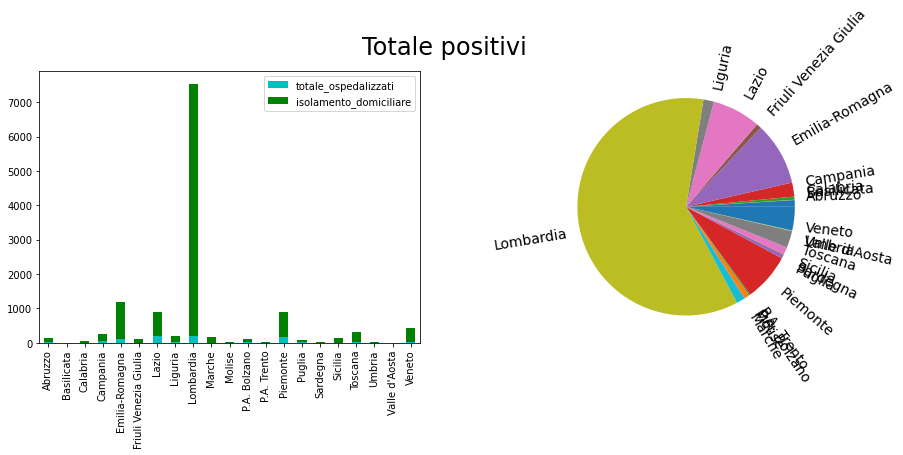

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = df_regioni_ultima_data.plot.bar(
    y=['totale_ospedalizzati', 'isolamento_domiciliare'], 
    stacked=True, 
    color=['c', 'green'], 
    ax=axes[0])
ax.set_xlabel(None)

ax = df_regioni_ultima_data.plot(
    y='totale_positivi', 
    legend=False, 
    fontsize=14, 
    kind='pie', 
    ax=axes[1], 
    rotatelabels=True)
ax.set_ylabel(None)

fig.suptitle('Totale positivi', fontsize=24);

La Lombardia si conferma tuttora la regione con più `totale_positivi` d'Italia, avendo la maggior parte dei casi.

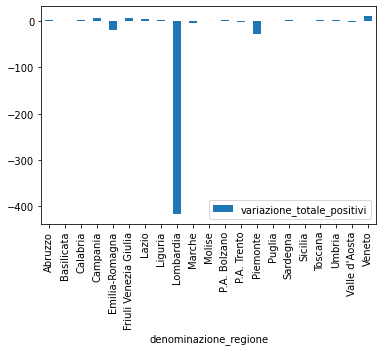

In [46]:
df_regioni_ultima_data.plot.bar(y=['variazione_totale_positivi']);

I dati della differenza prima di `totale_positivi` sembrano confermare una potenziale uscita dalla crisi.

### I "danni collaterali"

> Il termine *danni collaterali* appartiene al linguaggio militare per indicare le conseguenze indesiderate delle operazioni belliche che comportano costi altissimi in termini umani. Non sono però prerogativa esclusiva della guerra: i *danni collaterali* rappresentano uno degli aspetti più diretti e sconcertanti dell'ineguaglianza sociale che caratterizza la nostra epoca.

Bauman, Z., *Danni collaterali*, Editori Laterza, 2011

Gli indicatori più interessanti per fare un'analisi statica dei *danni collaterali* della pandemia sono `deceduti` e `totale_casi`.

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

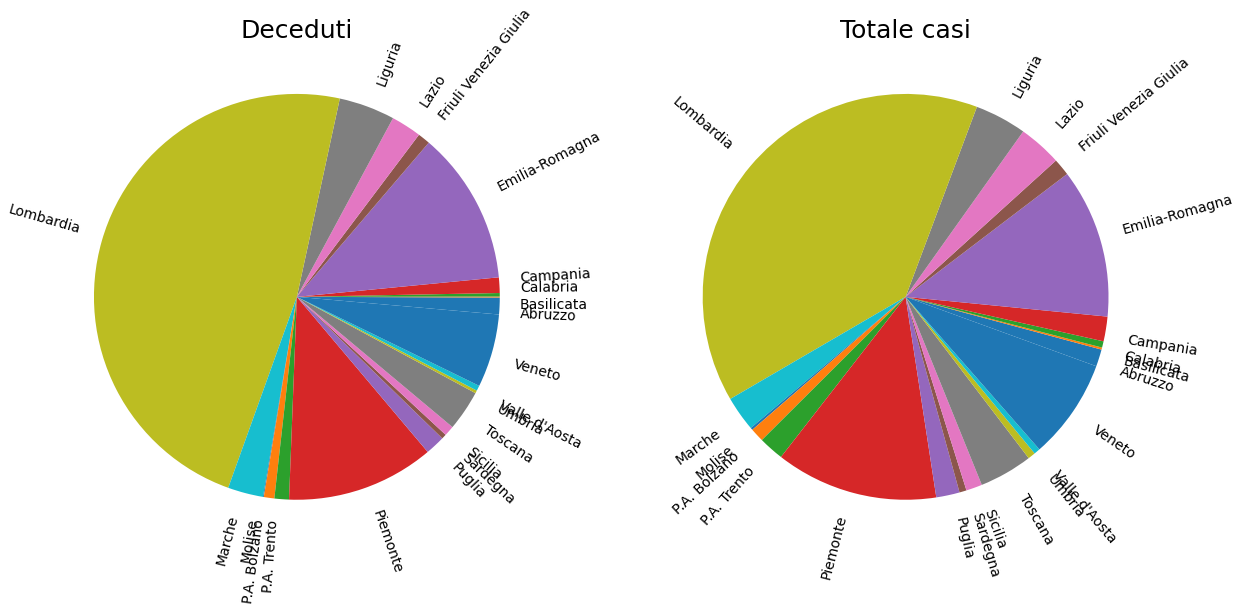

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = df_regioni_ultima_data.plot(
    y='deceduti', 
    ax=axes[0], 
    legend=False, 
    figsize=(20, 16), 
    fontsize=14, 
    kind='pie', 
    rotatelabels=True, 
    startangle=-5)
ax.set_title('Deceduti', fontsize=25)
ax.set_ylabel(None)


ax = df_regioni_ultima_data.plot(
    y='totale_casi', 
    ax=axes[1], 
    legend=False, 
    figsize=(20, 16), 
    fontsize=14, 
    kind='pie', 
    rotatelabels=True, 
    startangle=-20)
ax.set_title('Totale casi', fontsize=25)
ax.set_ylabel(None);

I `deceduti` della Lombardia sono quasi il 50% di tutti i `deceduti` d'Italia.

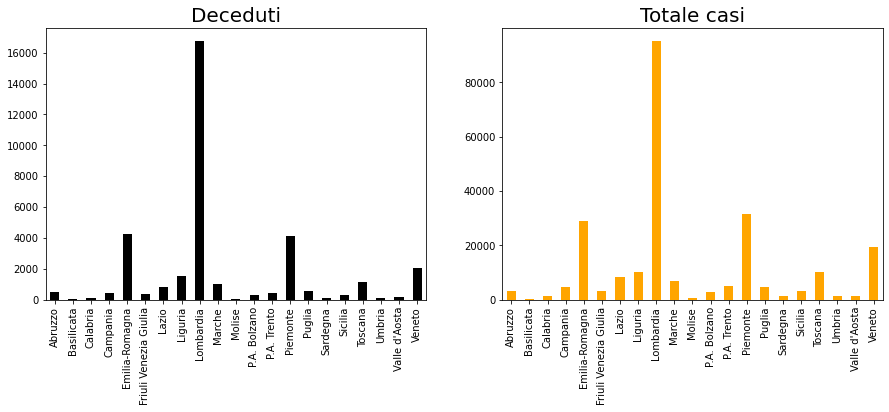

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = df_regioni_ultima_data.plot(y=['deceduti'], kind='bar', ax=axes[0], color=['black'], legend=False)
ax.set_title('Deceduti', fontsize=20)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax = df_regioni_ultima_data.plot(y=['totale_casi'], kind='bar', ax=axes[1], color='orange', legend=False)
ax.set_title('Totale casi', fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel(None);

È evidente come la regione principalmente colpita dalla pandemia sia la Lombardia, seguita dal Piemonte, Emilia-Romagna e Veneto, le principali regioni del Nord Italia. Questo dato, tuttavia, potrebbe risultare distorto a causa dell'elevata popolazione che abita in queste zone.

È opportuno verificare standardizzando i conteggi per 1000 abitanti.

In [49]:
# creiamo un DataFrame con i dati standardizzati per 1000 abitanti

df_regioni_ind = df_regioni.set_index(['denominazione_regione', 'data'])
regioni_mille_abitanti = []
voc = {}
popolazione_ind = popolazione.set_index('denominazione_regione')
voc['totale_positivi/1000_abitanti'] = df_regioni_ind['totale_positivi'] / (popolazione_ind['abitanti'] / 1000)
voc['deceduti/1000_abitanti'] = df_regioni_ind['deceduti'] / (popolazione_ind['abitanti'] / 1000)
voc['totale_casi/1000_abitanti'] = df_regioni_ind['totale_casi'] / (popolazione_ind['abitanti'] / 1000)
regioni_mille_abitanti.append(voc)
df_regioni_mille_abitanti = pd.DataFrame(voc).reset_index()

In [50]:
df_regioni_mille_abitanti.isnull().any()

denominazione_regione            False
data                             False
totale_positivi/1000_abitanti    False
deceduti/1000_abitanti           False
totale_casi/1000_abitanti        False
dtype: bool

In [51]:
# e prendiamo l'istantanea dell'ultima data disponibile
df_regioni_mille_abitanti_ultima_data = df_regioni_insta(ultima_data, df_regioni_mille_abitanti)
df_regioni_mille_abitanti_ultima_data

,totale_positivi/1000_abitanti,deceduti/1000_abitanti,totale_casi/1000_abitanti
denominazione_regione,,,
Abruzzo,0.094542,0.356059,2.539685
Basilicata,0.008883,0.047969,0.719528
Calabria,0.030301,0.049817,0.625536
Campania,0.044642,0.074461,0.825104
Emilia-Romagna,0.262363,0.957736,6.500538
Friuli Venezia Giulia,0.076529,0.283899,2.747651
Lazio,0.152745,0.144070,1.424712
Liguria,0.126399,1.006681,6.476036
Lombardia,0.748963,1.666406,9.466259


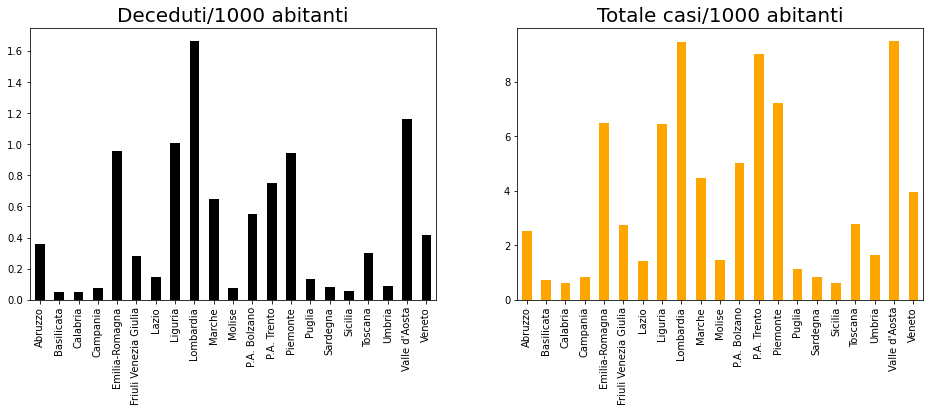

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
ax = df_regioni_mille_abitanti_ultima_data.plot(y=['deceduti/1000_abitanti'], kind='bar', ax=axes[0], color='black', legend=False)
ax.set_title('Deceduti/1000 abitanti', fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax = df_regioni_mille_abitanti_ultima_data.plot(y=['totale_casi/1000_abitanti'], kind='bar', ax=axes[1], color='orange', legend=False)
ax.set_title('Totale casi/1000 abitanti', fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel(None);

Grazie a questi plot possiamo notare che la Valle d'Aosta è la regione che ha avuto il maggior numero di casi ogni 1000 abitanti, intuizione non deducibile dai dati assoluti.

Guardare il tasso di letalità invece ci permette di comprendere meglio dove il virus sia stato più invasivo.

In [53]:
# ripetiamo le stesse operazioni sopra anche per il tasso di letalità

# impostiamo un multi-indice affinché si possa lavorare sia su base giornaliera che su base regionale
df_regioni_ind = df_regioni.set_index(['data', 'denominazione_regione'])
tasso_letalità = df_regioni_ind['deceduti'] / df_regioni_ind['totale_casi']
tasso_letalità.isnull().any()

True

Sembrerebbero esserci valori di `tasso_letalità` nulli. Un breve ragionamento ci porta a dedurre che i valori mancanti corrispondono a quelle regioni che per un primissimo periodo non hanno avuto né decessi né casi, portando dunque il codice ad effettuare una divisione 0/0 che ha restituito valori nulli. Si procede dunque a riempire questi dati mancanti con 0.

In [54]:
tasso_letalità = tasso_letalità.fillna(0)

In [55]:
tasso_letalità.isnull().any()

False

In [56]:
tasso_letalità_ultima_data = df_regioni_insta(ultima_data, tasso_letalità)
tasso_letalità_ultima_data

denominazione_regione
Abruzzo                  0.140198
Basilicata               0.066667
Calabria                 0.079639
Campania                 0.090244
Emilia-Romagna           0.147332
Friuli Venezia Giulia    0.103324
Lazio                    0.101122
Liguria                  0.155447
Lombardia                0.176036
Marche                   0.145040
Molise                   0.051570
P.A. Bolzano             0.109077
P.A. Trento              0.082975
Piemonte                 0.130668
Puglia                   0.120458
Sardegna                 0.097384
Sicilia                  0.090851
Toscana                  0.109015
Umbria                   0.055096
Valle d'Aosta            0.122074
Veneto                   0.105087
dtype: float64

E plottando anche il *tasso di letalità*.

In [57]:
tasso_letalità_ultima_data

denominazione_regione
Abruzzo                  0.140198
Basilicata               0.066667
Calabria                 0.079639
Campania                 0.090244
Emilia-Romagna           0.147332
Friuli Venezia Giulia    0.103324
Lazio                    0.101122
Liguria                  0.155447
Lombardia                0.176036
Marche                   0.145040
Molise                   0.051570
P.A. Bolzano             0.109077
P.A. Trento              0.082975
Piemonte                 0.130668
Puglia                   0.120458
Sardegna                 0.097384
Sicilia                  0.090851
Toscana                  0.109015
Umbria                   0.055096
Valle d'Aosta            0.122074
Veneto                   0.105087
dtype: float64

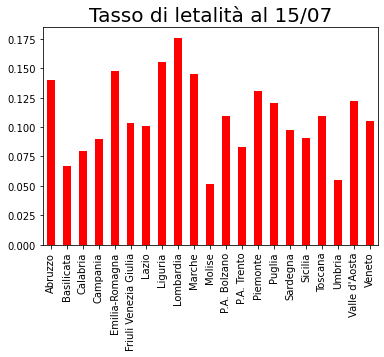

In [58]:
tasso_letalità_ultima_data.plot(kind='bar', color='red', legend=False)
plt.title('Tasso di letalità al ' + str(ultima_data.day) + '/0' + str(ultima_data.month), fontsize=20)
plt.xlabel(None)
plt.ylabel(None);

La mortalità più elevata in regioni come Lombardia, Abruzzo e Liguria potrebbe essere determinata da una molteplicità di fattori, tra cui la distribuzione della popolazione per età (i decessi si sono verificati principalmente tra persone anziane), la gestione delle RSA, la gestione delle strutture sanitarie.

Ma per capire meglio la variabile `totale_casi` bisogna ricorrere ad un'analisi delle le proporzioni con grafici a torta.

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspa

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

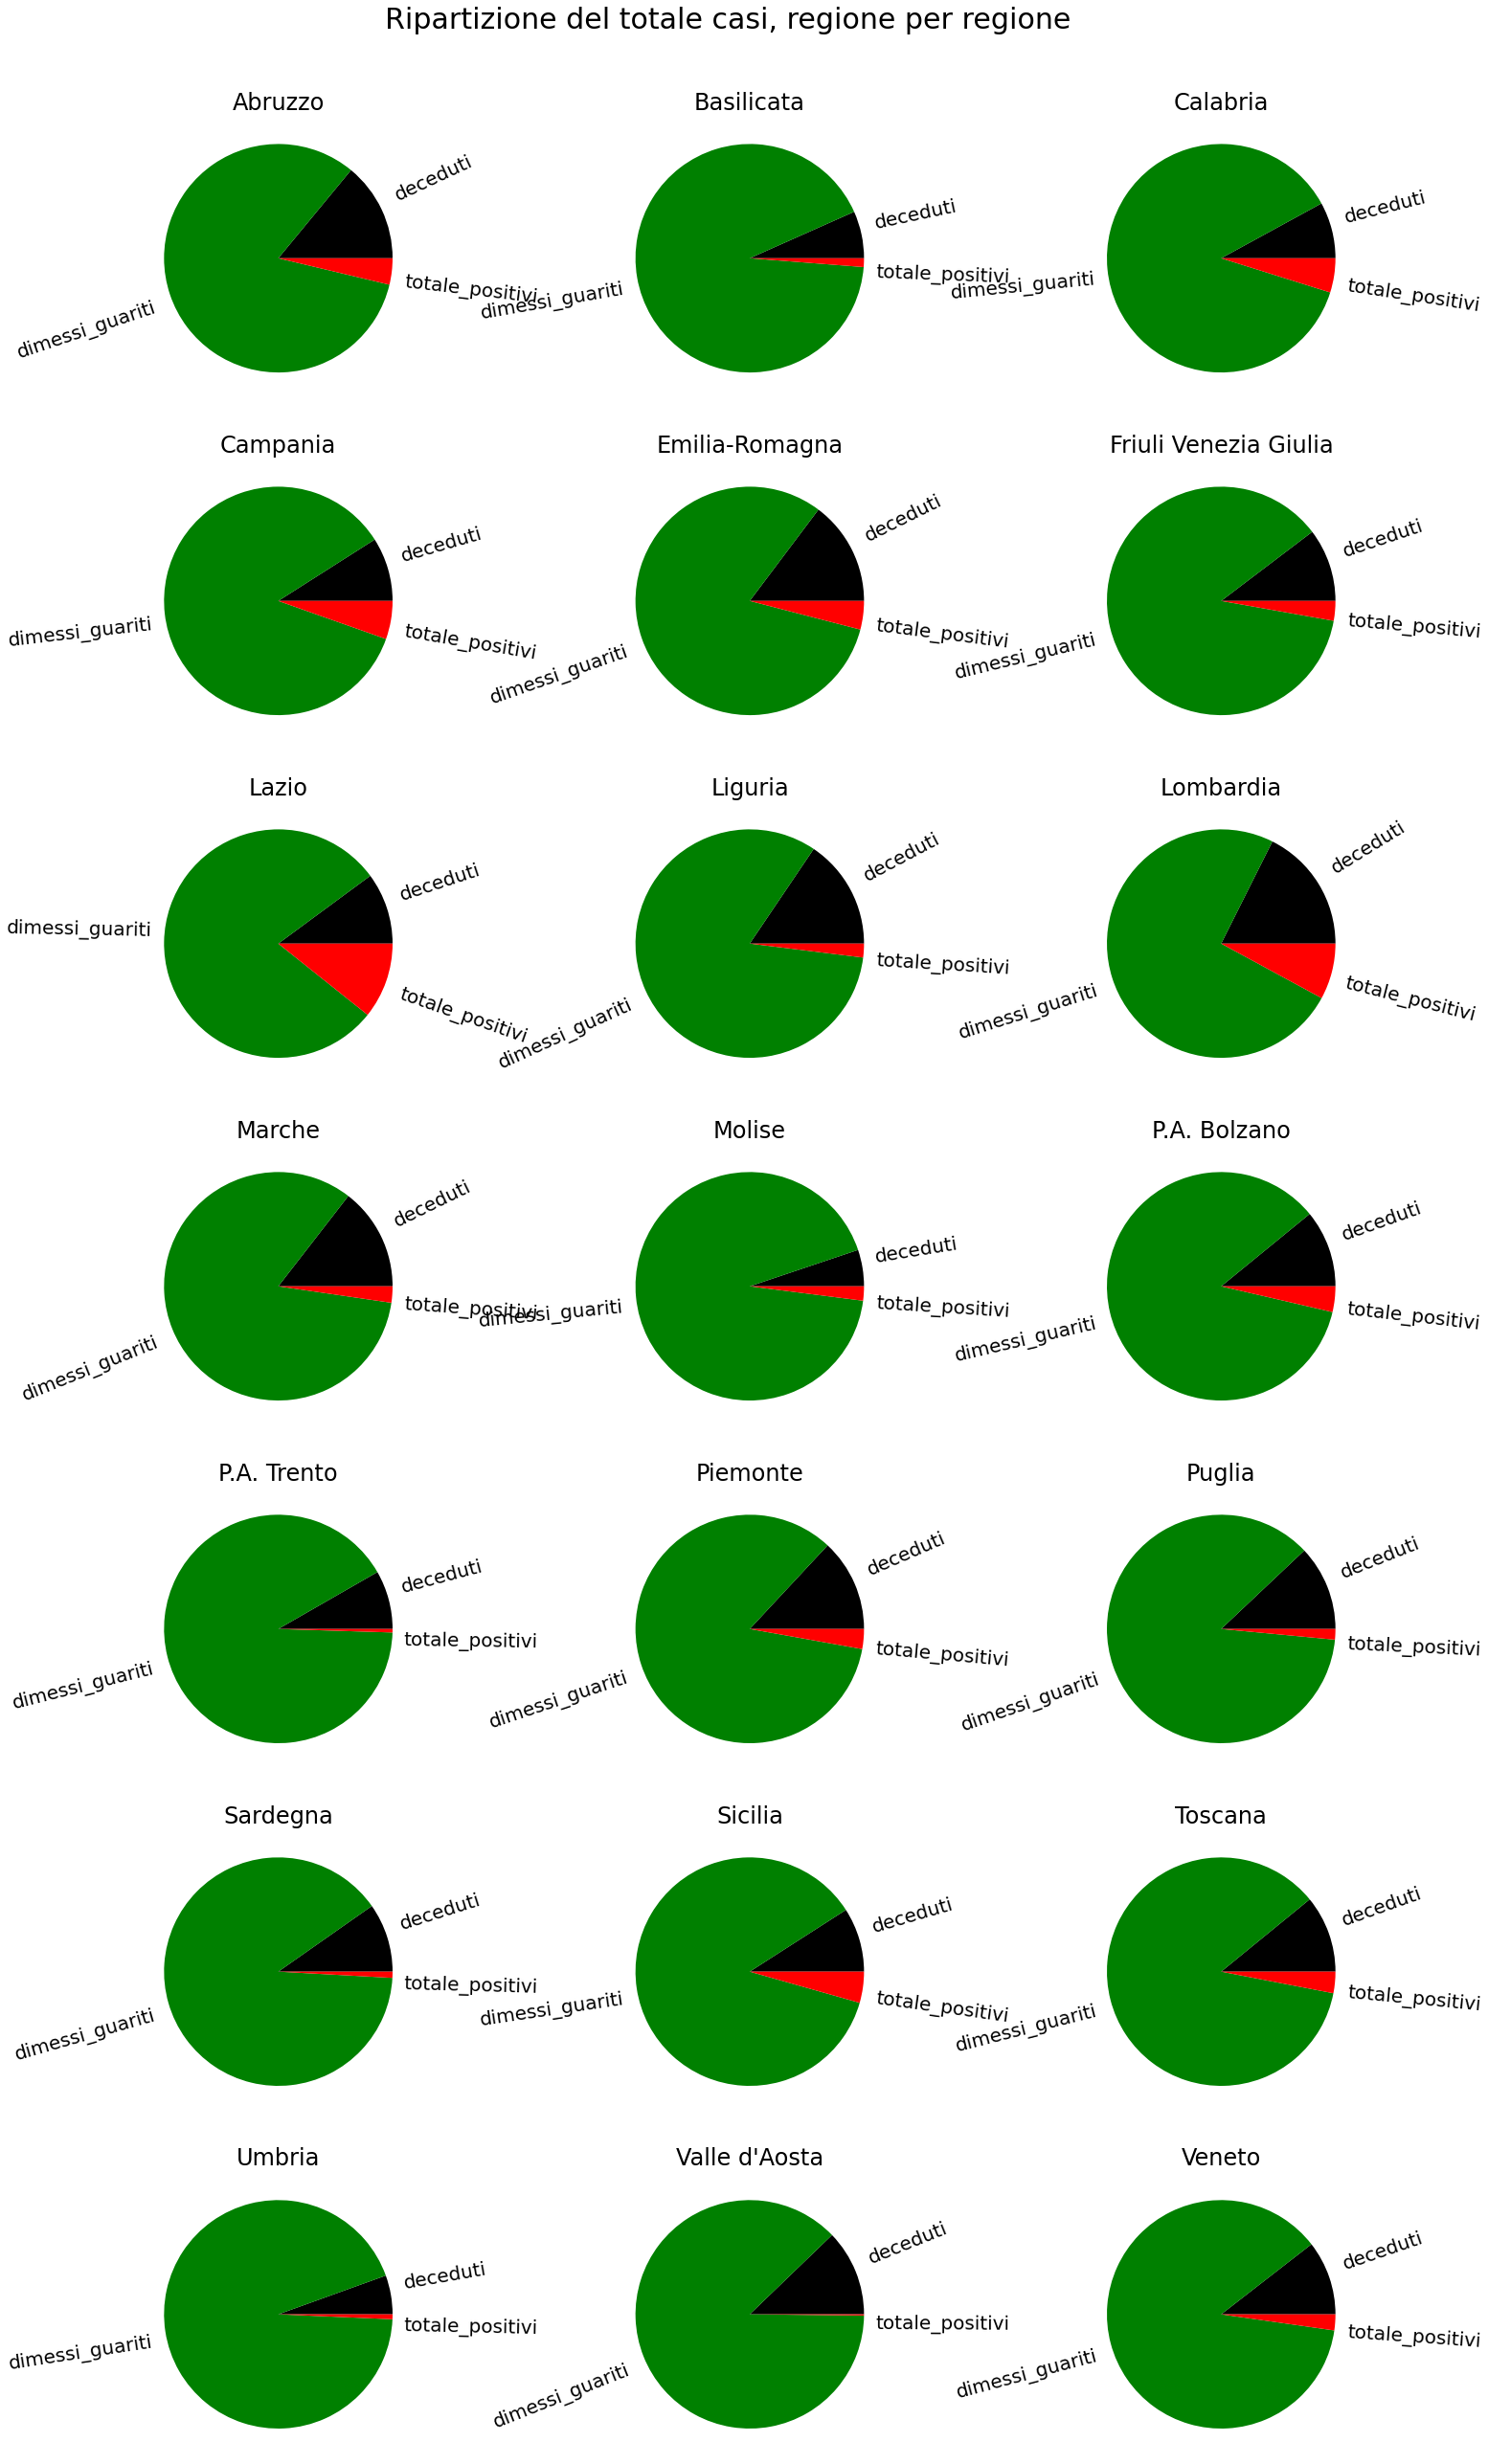

In [59]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(25, 45))
fig.suptitle('Ripartizione del totale casi, regione per regione', fontsize=30, y=0.915)
regione = 0

for i in range(1, len(nomi)+1): 
    plt.subplot(7, 3, i)
    df_regioni_ultima_data.iloc[regione][['deceduti', 'dimessi_guariti', 'totale_positivi']].plot(
        kind='pie', 
        colors=['black', 'green', 'red'], 
        rotatelabels=True, 
        fontsize=20)
    plt.title(nomi[regione], fontsize = 24) # possiamo prendere come indicatore la 
                                            # lista 'nomi' avendo mantenuto la corrispondenza 
                                            # con il DataFrame originale 
    plt.ylabel(None)
    regione += 1

## Un'analisi dinamica

Adesso cerchiamo di capire come si è evoluta l'epidemia nel tempo, tenendo in considerazione le varie fasi:
* Fase 0: **pre-lockdown** (24/02/2020 - 08/03/2020)
* Fase 1: **lockdown** (09/03/2020 - 03/05/2020)
* Fase 2: **allentamento delle misure di contenimento** (04/05/2020 - 14/06/2020)
* Fase 3: **convivenza con il COVID-19** (15/06/2020 - *in corso*)

*Fonte*: [Wikipedia](https://it.wikipedia.org/wiki/Pandemia_di_COVID-19_del_2020_in_Italia#Gestione_della_pandemia)

In [60]:
def df_regioni_din(col):
    
    '''Funzione che restituisce una pivot table della variabile passata in input, con le date sulle righe e le regioni
    sulle colonne.'''
    
    df = df_regioni.pivot_table(col, index='data', columns='denominazione_regione', aggfunc='max')
    return df

In [61]:
totale_casi = df_regioni_din('totale_casi')
deceduti = df_regioni_din('deceduti')
terapia_intensiva = df_regioni_din('terapia_intensiva')
totale_positivi = df_regioni_din('totale_positivi')
nuovi_positivi = df_regioni_din('nuovi_positivi')
variazione_totale_positivi = df_regioni_din('variazione_totale_positivi')

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

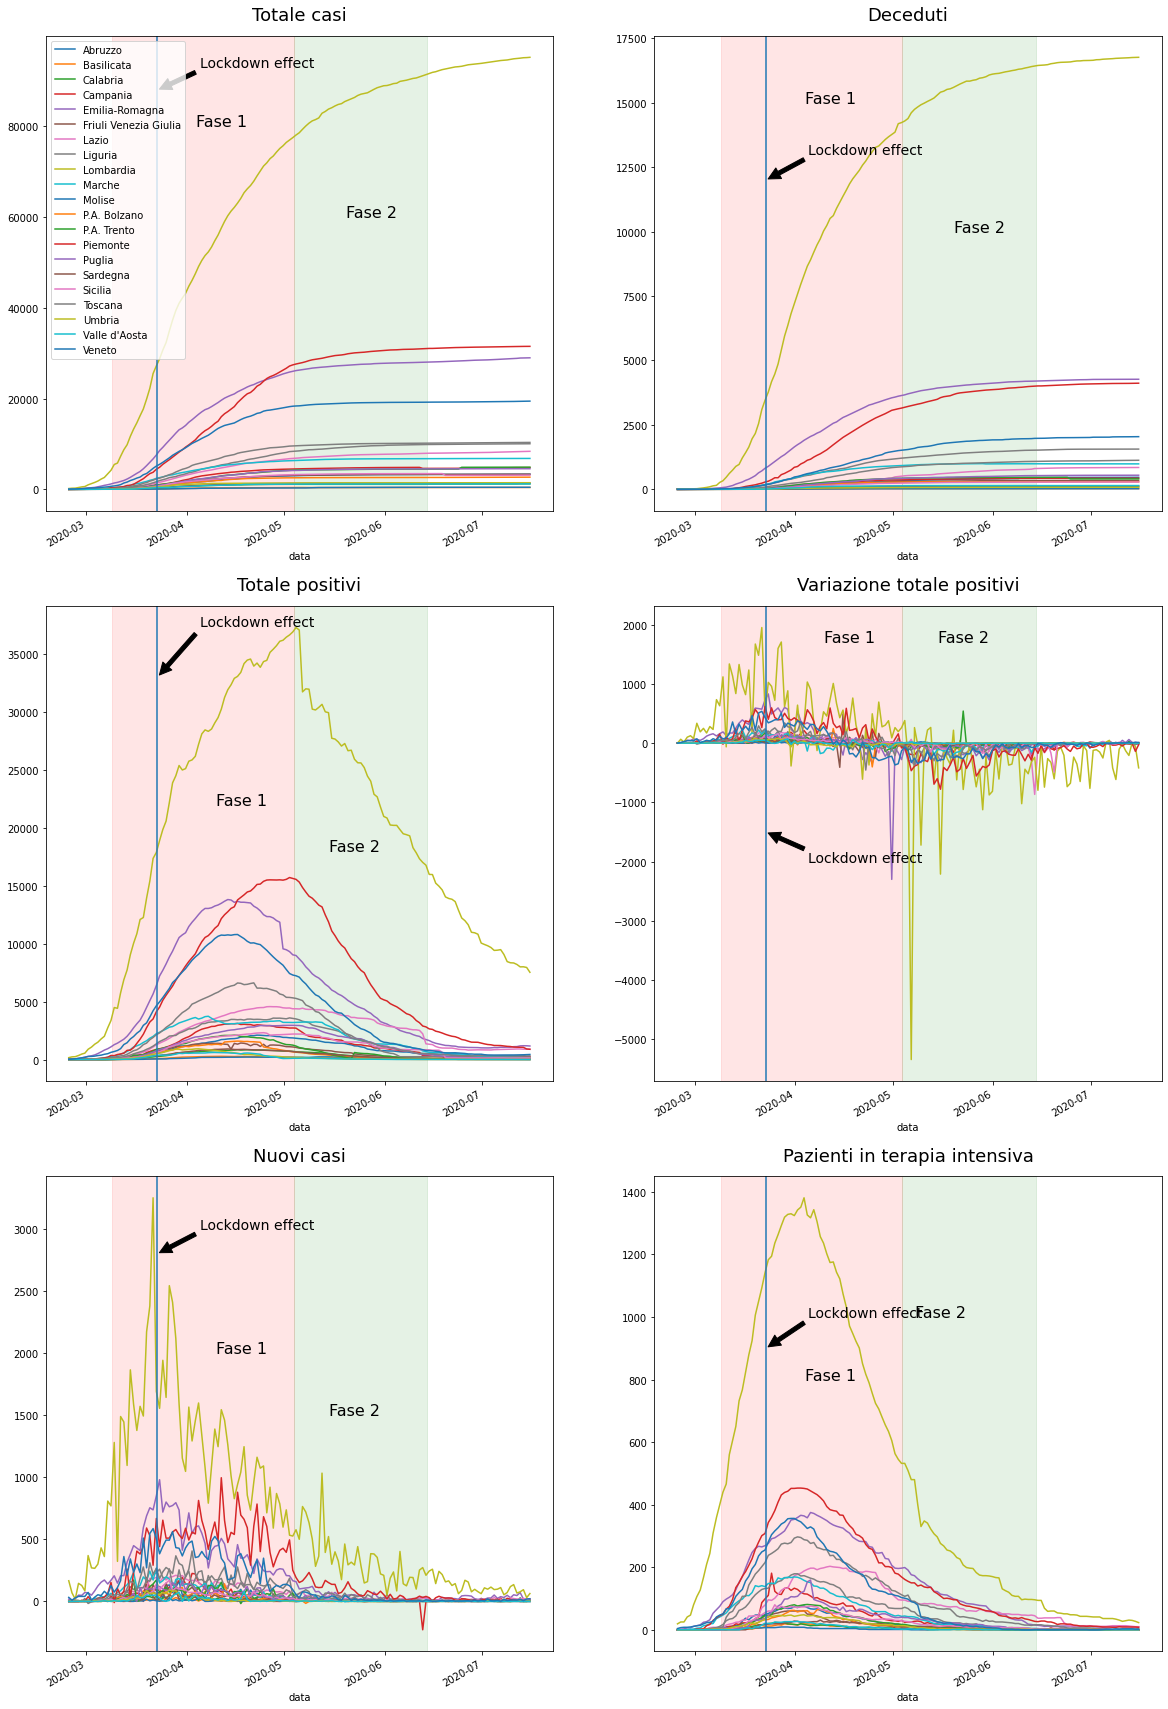

In [62]:
# plottare le pivot table ottenute sopra ci aiuta a capire meglio quale possano essere state le regioni più colpite

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 33))

ax1 = totale_casi.plot(ax=axes[0, 0], legend=False)
ax1.set_title('Totale casi', fontsize=18, y=1.02)
ax1.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax1.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax1.text('2020-04-04', 80000, 'Fase 1', size=16)
ax1.text('2020-05-20', 60000, 'Fase 2', size=16)
ax1.axvline('2020-03-23')
ax1.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', 88000), 
             xytext=('2020-04-05', 93000), 
             arrowprops=dict(facecolor='black', shrink=0.05))
ax1.legend()

ax2 = deceduti.plot(ax=axes[0, 1], legend=False)
ax2.set_title('Deceduti', fontsize=18, y=1.02)
ax2.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax2.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax2.text('2020-04-04', 15000, 'Fase 1', size=16)
ax2.text('2020-05-20', 10000, 'Fase 2', size=16)
ax2.axvline('2020-03-23')
ax2.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', 12000), 
             xytext=('2020-04-05', 13000), 
             arrowprops=dict(facecolor='black', shrink=0.05))

ax3 = totale_positivi.plot(ax=axes[1, 0], legend=False)
ax3.set_title('Totale positivi', fontsize=18, y=1.02)
ax3.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax3.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax3.text('2020-04-10', 22000, 'Fase 1', size=16)
ax3.text('2020-05-15', 18000, 'Fase 2', size=16)
ax3.axvline('2020-03-23')
ax3.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', 33000), 
             xytext=('2020-04-05', 37400), 
             arrowprops=dict(facecolor='black', shrink=0.05))

ax4 = variazione_totale_positivi.plot(ax=axes[1, 1], legend=False)
ax4.set_title('Variazione totale positivi', fontsize=18, y=1.02)
ax4.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax4.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax4.text('2020-04-10', 1700, 'Fase 1', size=16)
ax4.text('2020-05-15', 1700, 'Fase 2', size=16)
ax4.axvline('2020-03-23')
ax4.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', -1500), 
             xytext=('2020-04-05', -2000), 
             arrowprops=dict(facecolor='black', shrink=0.05));

ax5 = nuovi_positivi.plot(ax=axes[2, 0], legend=False)
ax5.set_title('Nuovi casi', fontsize=18, y=1.02)
ax5.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax5.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax5.text('2020-04-10', 2000, 'Fase 1', size=16)
ax5.text('2020-05-15', 1500, 'Fase 2', size=16)
ax5.axvline('2020-03-23')
ax5.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', 2800), 
             xytext=('2020-04-05', 3000), 
             arrowprops=dict(facecolor='black', shrink=0.05))

ax6 = terapia_intensiva.plot(ax=axes[2, 1], legend=False)
ax6.set_title('Pazienti in terapia intensiva', fontsize=18, y=1.02)
ax6.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax6.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax6.text('2020-04-04', 800, 'Fase 1', size=16)
ax6.text('2020-05-08', 1000, 'Fase 2', size=16)
ax6.axvline('2020-03-23')
ax6.annotate('Lockdown effect', 
             fontsize=14, 
             xy=('2020-03-23', 900), 
             xytext=('2020-04-05', 1000), 
             arrowprops=dict(facecolor='black', shrink=0.05));

Dai grafici sopra si può intuire come il lockdown abbia avuto un effetto netto su tutte le regioni: per rendercene conto meglio osserviamo meglio i grafici *Variazione totale positivi* e *Nuovi casi*. Interessante è anche il tracollo lombardo subito all'inizio della *Fase 2*.

Si può anche notare come la Lombardia sia stata la regione più colpita durante tutto il corso dell'epidemia: l'unica analisi statistica cui vale la pena approfondire è proprio quella che riguarda questa regione.

Per le altre regioni, a parte alcune del Nord, non sono nemmeno presenti i tratti caratteristici di un'epidemia.

Ha anche poco senso analizzare i dati nazionali: questi sono la somma di andamenti anche molto diversi nelle varie aree del paese e l'epidemia non ha comunicato tra le diverse aree a causa delle restrizioni governative sugli spostamenti.

### La Lombardia

In [63]:
Lombardia = df_regioni.set_index(['denominazione_regione', 'data']).loc['Lombardia']
Lombardia.head()

,stato,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
data,,,,,,,,,,,,,,,,,,,
2020-02-24 18:00:00,ITA,3,45.466794,9.190347,76,19,95,71,166,0,166,0,6,NaN,NaN,172,1463,877.269879,None
2020-02-25 18:00:00,ITA,3,45.466794,9.190347,79,25,104,127,231,65,68,0,9,NaN,NaN,240,3700,2218.659297,None
2020-02-26 18:00:00,ITA,3,45.466794,9.190347,79,25,104,145,249,18,18,0,9,NaN,NaN,258,3208,1923.637575,None
2020-02-27 18:00:00,ITA,3,45.466794,9.190347,172,41,213,136,349,100,145,40,14,NaN,NaN,403,3320,1990.796991,None
2020-02-28 18:00:00,ITA,3,45.466794,9.190347,235,47,282,192,474,125,128,40,17,NaN,NaN,531,4835,2899.248028,None


In [64]:
Lombardia.tail()

,stato,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
data,,,,,,,,,,,,,,,,,,,
2020-07-11 17:00:00,ITA,3,45.466794,9.190347,173,29,202,8010,8212,-129,67,70020,16740,89131.0,5841.0,94972,1133387,679427.0,None
2020-07-12 17:00:00,ITA,3,45.466794,9.190347,160,31,191,7813,8004,-208,77,70297,16748,89163.0,5886.0,95049,1142932,685763.0,None
2020-07-13 17:00:00,ITA,3,45.466794,9.190347,168,30,198,7813,8011,7,94,70375,16757,89209.0,5934.0,95143,1149414,689917.0,None
2020-07-14 17:00:00,ITA,3,45.466794,9.190347,176,27,203,7749,7952,-59,30,70461,16760,89200.0,5973.0,95173,1155050,693556.0,None
2020-07-15 17:00:00,ITA,3,45.466794,9.190347,177,23,200,7335,7535,-417,63,70936,16765,89240.0,5996.0,95236,1165476,699935.0,None


Iniziamo plottando la distribuzione dei casi positivi cumulati nel tempo in relazione ai nuovi casi giornalieri.

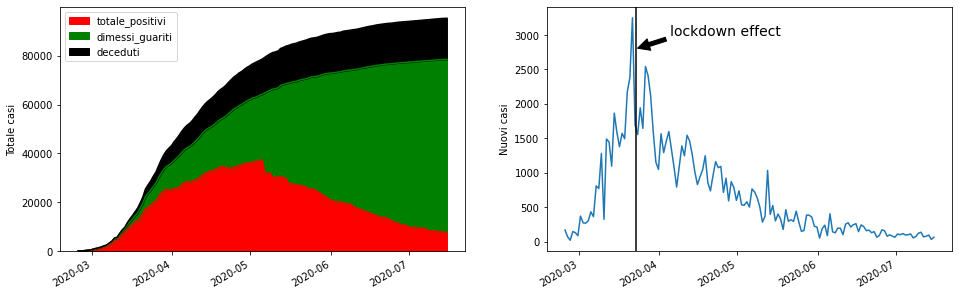

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = Lombardia.plot(y=['totale_positivi', 'dimessi_guariti', 'deceduti'], ax=axes[0], kind='area', color=['red', 'green', 'black'], stacked=True)
ax.set_xlabel(None)
ax.set_ylabel('Totale casi')

ax = Lombardia.plot(y='nuovi_positivi', ax=axes[1], legend=False)
ax.set_xlabel(None)
ax.set_ylabel('Nuovi casi')
ax.axvline('2020-03-23', color='black')
ax.annotate('lockdown effect', fontsize=14, xy=('2020-03-23', 2800), xytext=('2020-04-05', 3000), arrowprops=dict(facecolor='black', shrink=0.05));

Si può chiaramente vedere l'effetto del lockdown, circa 14 giorni dopo il suo inizio.

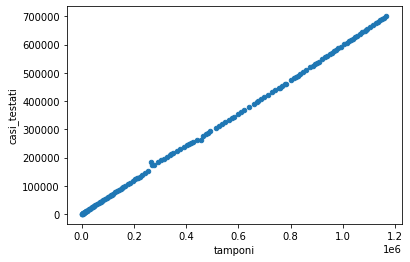

In [66]:
Lombardia.plot(x='tamponi', y='casi_testati', kind='scatter');

Lo scatter plot conferma quanto dicevamo prima riguardo la correlazione tra `tamponi` e `casi_testati`. Il rapporto si mantiene costante per tutta la durata dell'epidemia (circa il 60%).

### La terapia intensiva

Molto si è parlato riguardo la *terapia intensiva*. Il vero problema di questa epidemia non è il tasso di letalità che come si è visto è molto più basso rispetto ad altre epidemie (colera, peste, ebola, ecc.) ma il collasso del sistema sanitario.

Infatti una buona parte degli infetti da *Covid-19* richiedeva un'assistenza in terapia intensiva. Ma in Italia i posti in terapia intensiva sono limitati, come in tutto il resto del mondo: la capienza è molto più bassa del numero di persone che ne avrebbero necessitato se non avessimo preso dei provvedimenti per fermare l'epidemia.

In [67]:
posti_terapia_intensiva = posti_terapia_intensiva.set_index('denominazione_regione')
posti_terapia_intensiva

,capienza
denominazione_regione,
Abruzzo,115
Basilicata,49
Calabria,107
Campania,586
Emilia-Romagna,629
Friuli Venezia Giulia,127
Lazio,675
Liguria,186
Lombardia,1408


Fortunatamente al giorno d'oggi il sistema sanitario non è collassato. Ma potrebbe essere interessante vedere come si sono comportate le varie Regioni nella gestione dei posti in terapia intensiva, se questi sono arrivati quasi a livello di saturazione.

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fran/.local/share/virtualenvs/APAD_project-CDRFDThY/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

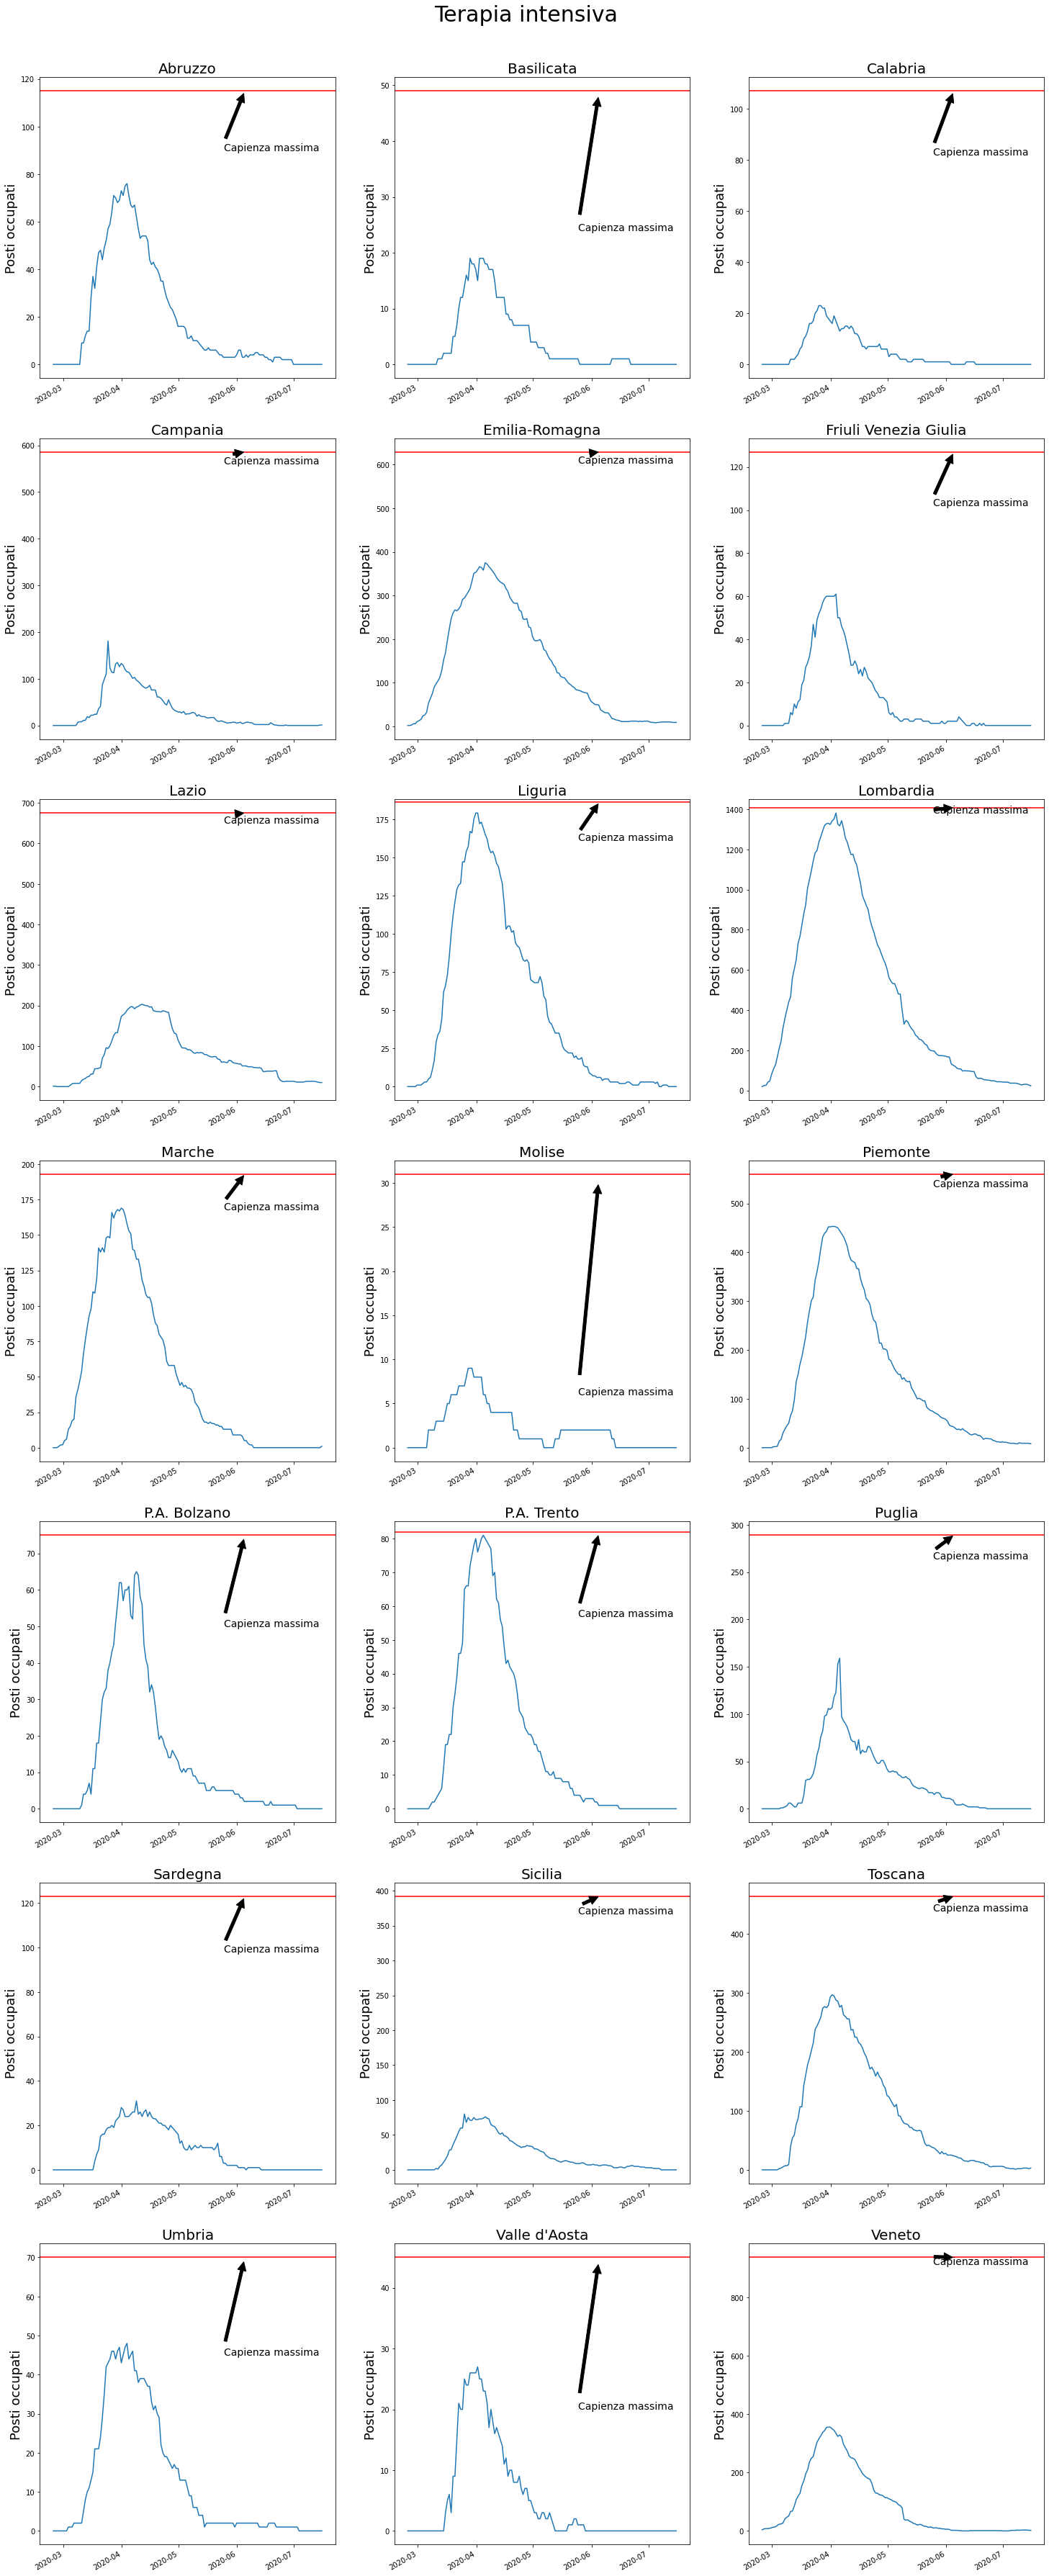

In [68]:
df_regioni_ind = df_regioni.set_index(['denominazione_regione', 'data'])
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(25, 70))
fig.suptitle('Terapia intensiva', fontsize=30, y=0.9)
i = 1
for regione in posti_terapia_intensiva.index: 
    ax = plt.subplot(7, 3, i)
    df_regioni_ind.loc[regione]['terapia_intensiva'].plot()   
    plt.title(regione, fontsize=20)
    plt.ylabel('Posti occupati', fontsize=18)
    plt.xlabel(None)
    cap = posti_terapia_intensiva.loc[regione]['capienza']
    ax.axhline(cap, color='red')
    ax.annotate('Capienza massima', fontsize=14, xy=('2020-06-05', cap), xytext=('2020-05-25', cap-25), arrowprops=dict(facecolor='black', shrink=0.05));
    i += 1

## Le Province

### I Dati

In [69]:
type(file_province) # verifichiamo di che tipo è il file appena aperto

list

In [70]:
type(file_province[0]) # e di che tipo sono gli elementi della lista

dict

In [71]:
file_province[0] # un controllo specifico del primo elemento della lista

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'codice_provincia': 66,
 'denominazione_provincia': "L'Aquila",
 'sigla_provincia': 'AQ',
 'lat': 42.35122196,
 'long': 13.39843823,
 'totale_casi': 0,
 'note': None}

In [72]:
file_province[1:3] # e così per un altro paio

[{'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'codice_provincia': 67,
  'denominazione_provincia': 'Teramo',
  'sigla_provincia': 'TE',
  'lat': 42.6589177,
  'long': 13.70439971,
  'totale_casi': 0,
  'note': None},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'codice_provincia': 68,
  'denominazione_provincia': 'Pescara',
  'sigla_provincia': 'PE',
  'lat': 42.46458398,
  'long': 14.21364822,
  'totale_casi': 0,
  'note': None}]

In [73]:
file_province[-2:] # anche degli ultimi due

[{'data': '2020-07-15T17:00:00',
  'stato': 'ITA',
  'codice_regione': 5,
  'denominazione_regione': 'Veneto',
  'codice_provincia': 899,
  'denominazione_provincia': 'Fuori Regione / Provincia Autonoma',
  'sigla_provincia': '',
  'lat': None,
  'long': None,
  'totale_casi': 332,
  'note': ''},
 {'data': '2020-07-15T17:00:00',
  'stato': 'ITA',
  'codice_regione': 5,
  'denominazione_regione': 'Veneto',
  'codice_provincia': 999,
  'denominazione_provincia': 'In fase di definizione/aggiornamento',
  'sigla_provincia': '',
  'lat': None,
  'long': None,
  'totale_casi': 23,
  'note': ''}]

Il file importato è una lista di dizionari, il formato di file perfetto per creare direttamente un `DataFrame` di `Pandas`.

In [74]:
df_province = pd.DataFrame(file_province)

In [75]:
df_province.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,None
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,None
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,None
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,None
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,None,NaN,NaN,0,None


In [76]:
df_province.tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
18740,2020-07-15T17:00:00,ITA,5,Veneto,27,Venezia,VE,45.434905,12.338452,2702,
18741,2020-07-15T17:00:00,ITA,5,Veneto,28,Padova,PD,45.406930,11.876087,3999,
18742,2020-07-15T17:00:00,ITA,5,Veneto,29,Rovigo,RO,45.071073,11.790070,446,
18743,2020-07-15T17:00:00,ITA,5,Veneto,899,Fuori Regione / Provincia Autonoma,,NaN,NaN,332,
18744,2020-07-15T17:00:00,ITA,5,Veneto,999,In fase di definizione/aggiornamento,,NaN,NaN,23,


#### Descrizione delle variabili: *dataset principale*

In [77]:
df_province.columns # verifichiamo quali sono le variabili a disposizione

Index(['data', 'stato', 'codice_regione', 'denominazione_regione',
       'codice_provincia', 'denominazione_provincia', 'sigla_provincia', 'lat',
       'long', 'totale_casi', 'note'],
      dtype='object')

Non sono presenti variabili inutili.

In [78]:
for var in df_province:
    print(type(df_province[var][0])) # verifichiamo di che tipo sono le variabili

<class 'str'>
<class 'str'>
<class 'numpy.int64'>
<class 'str'>
<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'NoneType'>


Le variabili a disposizione sono:
* `data`: la data esatta (*stringa*);
* `stato`: un unico stato, l'Italia (*stringa*);
* `codice_regione`: un numero assegnato ad ogni Regione (*intero*);
* `denominazione_regione`: il nome della Regione (*stringa*);
* `codice_provincia`: un numero assegnato ad ogni Provincia (*intero*);
* `denominazione_provincia`: il nome della Provincia (*stringa*);
* `sigla_provincia`: la sigla della Provincia (*stringa*);
* `lat`: la latitudine della Provincia (*float*);
* `long`: la longitudine della Provincia (*float*);
* `totale_casi`: il numero totale di casi positivi (*intero*);
* `note_it`: eventuali note in lingua italiana (*stringa*);
* `note_en`: eventuali note in lingua inglese (*stringa*).

Procediamo adesso trasformando la variabile `data` in un oggetto `datetime`, operazione che sarà utile successivamente nel definire gli indici.

In [79]:
df_province['data'] = pd.to_datetime(df_province['data'])

In [80]:
type(df_province['data'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [81]:
prima_data = df_province['data'].iloc[0] # definiamo la prima data per cui i dati sono disponibili
prima_data 

Timestamp('2020-02-24 18:00:00')

In [82]:
ultima_data = df_province['data'].iloc[-1] # e l'ultima
ultima_data

Timestamp('2020-07-15 17:00:00')

In [83]:
nomi = list(df_province['denominazione_provincia'].drop_duplicates()) # creiamo una lista di nomi non duplicati delle Province
nomi

["L'Aquila",
 'Teramo',
 'Pescara',
 'Chieti',
 'In fase di definizione/aggiornamento',
 'Potenza',
 'Matera',
 'Cosenza',
 'Catanzaro',
 'Reggio di Calabria',
 'Crotone',
 'Vibo Valentia',
 'Caserta',
 'Benevento',
 'Napoli',
 'Avellino',
 'Salerno',
 'Piacenza',
 'Parma',
 "Reggio nell'Emilia",
 'Modena',
 'Bologna',
 'Ferrara',
 'Ravenna',
 'Forlì-Cesena',
 'Rimini',
 'Udine',
 'Gorizia',
 'Trieste',
 'Pordenone',
 'Viterbo',
 'Rieti',
 'Roma',
 'Latina',
 'Frosinone',
 'Imperia',
 'Savona',
 'Genova',
 'La Spezia',
 'Varese',
 'Como',
 'Sondrio',
 'Milano',
 'Bergamo',
 'Brescia',
 'Pavia',
 'Cremona',
 'Mantova',
 'Lecco',
 'Lodi',
 'Monza e della Brianza',
 'Pesaro e Urbino',
 'Ancona',
 'Macerata',
 'Ascoli Piceno',
 'Fermo',
 'Campobasso',
 'Isernia',
 'Bolzano',
 'Trento',
 'Torino',
 'Vercelli',
 'Novara',
 'Cuneo',
 'Asti',
 'Alessandria',
 'Biella',
 'Verbano-Cusio-Ossola',
 'Foggia',
 'Bari',
 'Taranto',
 'Brindisi',
 'Lecce',
 'Barletta-Andria-Trani',
 'Sassari',
 'Nuoro'

Notiamo che ci sono dei dati sotto il nome `In fase di definizione/aggiornamento`. Questi sono dati sui contagi che non sono ancora stati allocati ad una Provincia specifica: li raggrupperemo sotto un'unica voce.

In [84]:
df_province.describe() # una statistica descrittiva delle variabili numeriche del dataset

,codice_regione,codice_provincia,lat,long,totale_casi
count,18745.000000,18745.000000,15301.000000,15301.000000,18745.000000
mean,10.597386,223.556042,42.908522,12.096599,1269.916244
std,6.093018,358.486337,2.631595,2.660633,2598.915465
min,1.000000,1.000000,36.925092,7.320149,0.000000
25%,5.000000,33.000000,40.914047,9.828190,51.000000
50%,10.000000,66.000000,43.715532,12.104734,382.000000
75%,16.000000,99.000000,45.185093,14.167546,1261.000000
max,22.000000,999.000000,46.499335,18.171897,24644.000000


In [85]:
df_province.isnull().any() # verifico se sono presenti dati mancanti

data                       False
stato                      False
codice_regione             False
denominazione_regione      False
codice_provincia           False
denominazione_provincia    False
sigla_provincia             True
lat                         True
long                        True
totale_casi                False
note                        True
dtype: bool

## L'analisi

Il dataset risulta molto meno interessante di quello sulle Regioni. Potremo solo fare statistiche su `totale_casi`, dato cumulato. Procediamo prendendo in analisi soltanto le 10 Province con il numero maggiore di casi.

In [86]:
df_province_ind = df_province.set_index(['data', 'denominazione_regione', 'sigla_provincia'])
df_province_oggi = df_province_ind.loc[ultima_data]
df_province_oggi.head()

stato  codice_regione  codice_provincia  \
denominazione_regione sigla_provincia                                           
Abruzzo               AQ                ITA              13                66   
                      TE                ITA              13                67   
                      PE                ITA              13                68   
                      CH                ITA              13                69   
                                        ITA              13               879   

                                                  denominazione_provincia  \
denominazione_regione sigla_provincia                                       
Abruzzo               AQ                                         L'Aquila   
                      TE                                           Teramo   
                      PE                                          Pescara   
                      CH                                           Chieti   
                                       Fuori Regione / Provincia Autonoma   

                                             lat       long  totale_casi note  
denominazione_regione sigla_provincia                                          
Abruzzo               AQ               42.351222  13.398438          240       
                      TE               42.658918  13.704400          635       
                      PE               42.464584  14.213648         1599       
                      CH               42.351032  14.167546          827       
                                             NaN        NaN           26

In [87]:
df_province_10_oggi = df_province_oggi.sort_values('totale_casi', ascending=False)[:10]
df_province_10_oggi.index

MultiIndex([(     'Lombardia', 'MI'),
            (      'Piemonte', 'TO'),
            (     'Lombardia', 'BS'),
            (     'Lombardia', 'BG'),
            (     'Lombardia', 'CR'),
            (         'Lazio', 'RM'),
            (     'Lombardia', 'MB'),
            (       'Liguria', 'GE'),
            (     'Lombardia', 'PV'),
            ('Emilia-Romagna', 'BO')],
           names=['denominazione_regione', 'sigla_provincia'])

A parte che per le 6 in Lombardia e Roma, le altre sono le città più popolose del Nord (Torino, Bologna e Genova). 

In [88]:
df_province_10_oggi = df_province_10_oggi.reset_index().set_index('sigla_provincia')

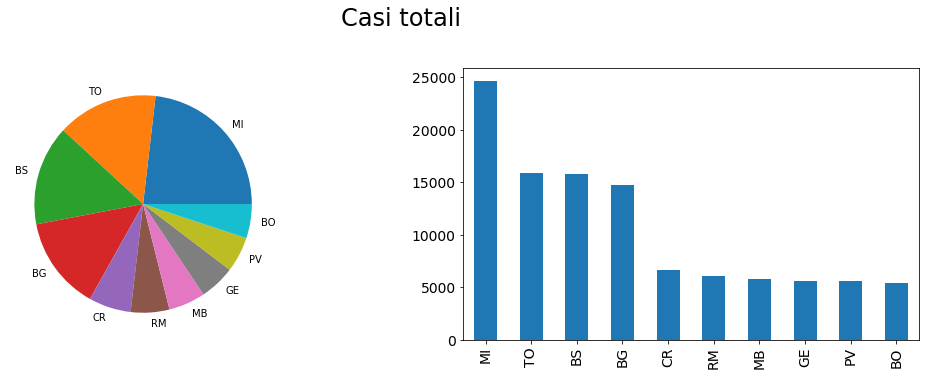

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax = df_province_10_oggi.plot(y='totale_casi', kind='pie', ax=axes[0], legend=False)
ax.set_ylabel(None);
ax = df_province_10_oggi.plot(y='totale_casi', legend=False, fontsize=14, kind='bar', ax=axes[1])
ax.set_ylabel(None)
ax.set_xlabel(None)
fig.suptitle('Casi totali', fontsize=24, y=1.05);

Milano, senza dubbio, è la locomotiva dell'epidemia.

Infine, diamo un'ultima occhiata all'evoluzione temporale.

In [90]:
cities = list(df_province_10_oggi.index)
cities

['MI', 'TO', 'BS', 'BG', 'CR', 'RM', 'MB', 'GE', 'PV', 'BO']

In [91]:
df_province_10 = df_province.pivot_table('totale_casi', index='data', columns='sigla_provincia', aggfunc='max')
df_province_10 = df_province_10[cities]

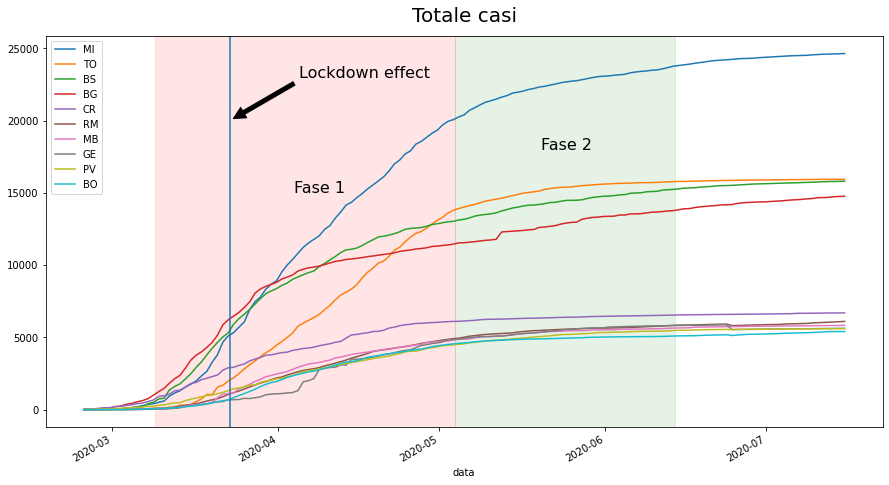

In [92]:
ax = df_province_10.plot(legend=False, figsize=(15,8))
ax.set_title('Totale casi', fontsize=20, y=1.02)
ax.axvspan('2020-03-09', '2020-05-04', color='red', alpha=0.1)
ax.axvspan('2020-05-04', '2020-06-14', color='green', alpha=0.1)
ax.text('2020-04-04', 15000, 'Fase 1', size=16)
ax.text('2020-05-20', 18000, 'Fase 2', size=16)
ax.axvline('2020-03-23')
ax.annotate('Lockdown effect', 
            fontsize=16, 
            xy=('2020-03-23', 20000), 
            xytext=('2020-04-05', 23000), 
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.legend();

Come possiamo ben vedere, le 10 Province hanno tutte avuto andamenti diversi: intuizione che conferma che i tratti caratteristici dell'epidemia si siano manifestati soltanto in Lombardia. 